In [1]:
import rasterio
import numpy as np
import pandas as pd
from rasterio.crs import CRS
from glob import glob
from rasterio import plot
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
pd.options.display.max_rows = 10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import scipy.io
import copy
%matplotlib inline

In [2]:
def get_anc_df(month):
    cygnss_data = pd.read_csv('C:/Cygnss/report/cygnss_csv/'+month+'_quality_rough_above_thresh.csv')
    if month == 'april':
        ind = (cygnss_data[cygnss_data['sp_lon'] == -98.58905029296876]).index
        cygnss_data.drop(ind, inplace = True)
        cygnss_data.reset_index(drop = True, inplace = True)
    preff = cygnss_data['preff']
    pow_mean = cygnss_data['pow_mean']
    pow_var = cygnss_data['pow_var']
    pow_skew = cygnss_data['pow_skew']
    pow_kurt = cygnss_data['pow_kurt']
    sp_lat = cygnss_data['sp_lat']
    sp_lon = cygnss_data['sp_lon']
    inc_angle = cygnss_data['sp_inc_angle']
    day_num = cygnss_data['day']
    
    soil_files_list = glob('soils/soils/*.tif')
    ele_files_list = glob('3dep_13/3dep_13/*.tif')
    
    ndvi = rasterio.open('report/ancillary/modis_ndvi/'+month+'/ndvi_'+month+'_reprojected.tif')
    elevation = rasterio.open(ele_files_list[0])
    clay = rasterio.open(soil_files_list[0])
    depres = rasterio.open(soil_files_list[1])
    sand = rasterio.open(soil_files_list[2])
    silt = rasterio.open(soil_files_list[3])
    
    elevation_data = elevation.read(1)
    clay_data = clay.read(1)
    depres_data = depres.read(1)
    sand_data = sand.read(1)
    silt_data = silt.read(1)
    ndvi_data = ndvi.read(1)

    clay_data = np.where(
    clay_data < 0,
    0.,
    clay_data)

    sand_data = np.where(
    sand_data < 0,
    0.,
    sand_data)

    silt_data = np.where(
    silt_data < 0,
    0.,
    silt_data)

    depres_data = np.where(
    depres_data < 0,
    0.,
    depres_data)

    eles = []
    cls = []
    snds = []
    sils = []
    deps = []
    ndvis = []
    for i in range(cygnss_data.shape[0]):
            
        lat = sp_lat[i]
        lon = sp_lon[i]



        ele_ind = elevation.index(lon, lat)
#         if ((month=='april')&(ele_ind[1] == 4035)):
#             ele_ind = elevation.index(lon, lat)
#             print(ele_ind)
#             print(lat, lon)
#             ele_ind = (ele_ind[0], 4033)
        clay_ind = clay.index(lon, lat)
        sand_ind = sand.index(lon, lat)
        silt_ind = silt.index(lon, lat)
        depres_ind = depres.index(lon, lat)
        ndvi_ind = ndvi.index(lon, lat)

        eles.append(elevation_data[ele_ind])
        cls.append(clay_data[clay_ind])
        snds.append(sand_data[sand_ind])
        sils.append(silt_data[silt_ind])
        deps.append(depres_data[depres_ind])
        ndvis.append(ndvi_data[ndvi_ind])
        
    d = {'day_num':day_num, 'lat':sp_lat, 'lon': sp_lon,
         'preff':preff, 'inc_angle':inc_angle, 'elevation':eles,
         'clay':cls, 'sand':snds, 'silt':sils, 'depres':deps, 
         'ndvi':ndvis, 'pow_mean': pow_mean, 'pow_var':pow_var, 'pow_skew':pow_skew, 'pow_kurt':pow_kurt}
    
#     d = {'day_num':day_num, 'lat':sp_lat, 'lon': sp_lon,
#          'preff':preff, 'inc_angle':inc_angle, 'elevation':eles,
#          'clay':cls, 'sand':snds, 'silt':sils, 'depres':deps, 
#          'ndvi':ndvis}
    anc_data = pd.DataFrame(d)
    
    return anc_data

In [3]:
jan = get_anc_df('jan')
april = get_anc_df('april')
july = get_anc_df('july')
jan_clean = jan.dropna()
april_clean = april.dropna()
july_clean = july.dropna()

In [4]:
np.round(pearsonr(jan_clean['preff'], jan_clean['clay']),3)

array([-0.24,  0.  ])

In [5]:
month_to_num_days = {'jan':31,
                    'april':30,
                    'july':31}

method_to_txson_type = {'idw':'SWCi',
                    'voronoi':'SWCv'}

method_to_cygnss_type = {'idw':'CYGNSSi',
                        'voronoi':'CYGNSSv'}
month_to_smap_lower = {
    'jan':1,
    'april':91,
    'july':182
}

month_to_smap_upper = {
    'jan':31,
    'april':120,
    'july':212
}

In [6]:
# Set the required grid resolution here (3km or 9km)
grid_res = '3km'

snr = 0
preff = 1

In [7]:
def get_txson_smap(month, method, grid_res=grid_res):
    
    txson_path = 'C:/Cygnss/TxSON_v1_3/TxSON_v1_3/TxSON_upscaled/txson_' + month + '_'+method +'_'+ grid_res + '.mat'
    txson = scipy.io.loadmat(txson_path)
    
    txson_type = method_to_txson_type[method]
    TxSON = txson[txson_type][:,:,0]
    
#     cygnss_path = 'cygnss_upscaled_2/cygnss_' + month + '_quality_'+ method + '_'+ grid_res + '.mat'
# #     cygnss_path = 'cygnss_upscaled_2/cygnss_' + month + '_' + method + '_'+ grid_res + '.mat'
#     cygnss = scipy.io.loadmat(cygnss_path)
    
#     cygnss_type = method_to_cygnss_type[method]
#     CYGNSS = cygnss[cygnss_type]
    
    
    month_lower_day = month_to_smap_lower[month]
    month_upper_day = month_to_smap_upper[month]
    SMAP = np.empty((month_to_num_days[month], TxSON.shape[1]))
    SMAP[:] = np.NaN
    smap_data_path = 'C:/Cygnss/smap/'+grid_res+'/smap_sm_9km_2019*.tif'
    smap_2019_files_list = glob(smap_data_path)
    smap_month_list = [x for x in smap_2019_files_list if ((int(x[-7:-4])>=month_lower_day) & (int(x[-7:-4])<=month_upper_day))]
    
    for i in range(len(smap_month_list)):
        smap = rasterio.open(smap_month_list[i])
        smap_1 = smap.read(1).astype('float64')
        smap_2 = smap.read(2).astype('float64')
        smap_avg = np.nanmean(np.array([smap_1, smap_2]), axis = 0)
#         smap_avg = (np.add(smap_1, smap_2))/2
    
        #reorder smap data according to the fishnet order of grids
        smap_avg_reordered = smap_avg[[3, 2, 1, 0]]

        smap_avg_flatten = smap_avg_reordered.flatten()
        SMAP[i,:] = smap_avg_flatten
        
    
    return TxSON, SMAP

In [8]:
TxSON_jan, SMAP_jan = get_txson_smap('jan', 'voronoi')
TxSON_april, SMAP_april = get_txson_smap('april', 'voronoi')
TxSON_july, SMAP_july = get_txson_smap('july', 'voronoi')

C:\Users\mathurs\Anaconda3\envs\geo_env_2\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [9]:
fishnet_path = 'C:/Cygnss/grid_corners/fishnet_' + grid_res +'.shp'
fishnet = gpd.read_file(fishnet_path)
grid_corners_path = 'C:/Cygnss/grid_corners/fishnet_' + grid_res +'.csv'
grid_corners = pd.read_csv(grid_corners_path)

In [12]:
def get_merged_fishnet(fishnet, month, TxSON, SMAP):
    
    num_days = month_to_num_days[month]
    txson_fishnet = copy.deepcopy(fishnet)
    smap_fishnet = copy.deepcopy(fishnet)
    month_days = np.arange(num_days)
#     for day in month_days:
#         preff_day = CYGNSS[day,:, preff]
#         preff_day_number = 'preff_day_' + str(day+1)
#         merged_fishnet[preff_day_number] = preff_day 
        
    
    cell_num = 144
    grids_month_mean = np.zeros((cell_num,))
    
#     for i in range(16):
#         grid_mean = np.nanmean(CYGNSS[:,i,preff])
#         grids_month_mean[i] = grid_mean
#     merged_fishnet['preff_month_mean'] = grids_month_mean
    
    for day in month_days:
        lower = (day)*24
        upper = lower+24
        txson_fishnet['txson_day_'+str(day+1)] = np.nanmean(TxSON[lower:upper,:], axis = 0)  
#     merged_fishnet['txson_month_mean'] = np.nanmean(TxSON, axis = 0) 
    
    for day in month_days:
        smap_day = SMAP[day, :]
        smap_day_number = 'smap_day_'+str(day+1)
        smap_fishnet[smap_day_number] = smap_day
        
    grids_month_mean = np.zeros((cell_num,))
    for i in range(SMAP.shape[1]):
        grid_mean = np.nanmean(SMAP[:,i])
        grids_month_mean[i] = grid_mean
#     merged_fishnet['smap_month_mean'] = grids_month_mean
        
    
    return txson_fishnet, smap_fishnet   

In [13]:
jan_txson, jan_smap = get_merged_fishnet(fishnet, 'jan', TxSON_jan, SMAP_jan)
april_txson, april_smap = get_merged_fishnet(fishnet, 'april', TxSON_april, SMAP_april)
july_txson, july_smap = get_merged_fishnet(fishnet, 'july', TxSON_july, SMAP_july)

C:\Users\mathurs\Anaconda3\envs\geo_env_2\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


In [14]:
jan_txson.iloc[3]

Id                                                              0
geometry        POLYGON ((-98.86929499999999 30.149063, -98.86...
txson_day_1                                              0.335167
txson_day_2                                              0.387875
txson_day_3                                              0.408625
                                      ...                        
txson_day_27                                             0.377417
txson_day_28                                               0.3535
txson_day_29                                             0.339458
txson_day_30                                              0.33375
txson_day_31                                             0.332208
Name: 3, Length: 33, dtype: object

In [15]:
def get_txson_gt(month_clean, month_txson, month):
    txson_gt = []
    for i in range(month_clean.shape[0]):
        day_num = int(month_clean.iloc[i]['day_num'])
        sp_lat = month_clean.iloc[i]['lat']
        sp_lon = month_clean.iloc[i]['lon']
        for j in range(grid_corners.shape[0]):
            grid_lat_min = grid_corners.iloc[j]['LAT_corner_min']
            grid_lat_max = grid_corners.iloc[j]['LAT_corner_max']
            grid_lon_min = grid_corners.iloc[j]['LON_corner_min']
            grid_lon_max = grid_corners.iloc[j]['LON_corner_max']
            if ((sp_lat>grid_lat_min)&(sp_lat < grid_lat_max)&(sp_lon > grid_lon_min)&(sp_lon < grid_lon_max)):
                grid_ind = int(j)
    #             print(grid_ind)
                break

        txson_gt.append(month_txson.iloc[grid_ind][day_num-month_to_smap_lower[month]+2])
    return txson_gt

In [16]:
jan_txson_gt = get_txson_gt(jan_clean, jan_txson, 'jan')
jan_clean['txson_gt'] = jan_txson_gt
april_txson_gt = get_txson_gt(april_clean, april_txson, 'april')
april_clean['txson_gt'] = april_txson_gt
july_txson_gt = get_txson_gt(july_clean, july_txson, 'july')
july_clean['txson_gt'] = july_txson_gt

C:\Users\mathurs\Anaconda3\envs\geo_env_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mathurs\Anaconda3\envs\geo_env_2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
dataset = pd.concat([jan_clean, april_clean, july_clean]).reset_index()
# dataset = dataset.drop(columns=['elevation', 'day_num', 'lat', 'lon', 'sand', 'silt', 'depres', 'ndvi'])

In [18]:
dataset.to_csv('C:/Cygnss/report/ML/data_3km.csv', index = False)

In [19]:
data = pd.read_csv('C:/Cygnss/report/ML/data_3km.csv')

In [20]:
data.iloc[:,4:-1]

,preff,inc_angle,elevation,clay,sand,silt,depres,ndvi,pow_mean,pow_var,pow_skew,pow_kurt
0,152.839042,37.919052,500.277008,50.0,22.1,27.9,201.0,4562,-690.990051,6432023.0,-3.397408,9.544185
1,152.661684,37.938034,486.428375,17.5,43.0,39.5,201.0,4416,-690.990051,6432023.0,-3.397408,9.544185
2,152.786237,37.957127,480.731262,10.5,76.0,13.5,201.0,3901,-690.990051,6432023.0,-3.397408,9.544185
3,151.391626,37.976330,483.185364,22.5,39.8,37.7,46.0,5288,-690.990051,6432023.0,-3.397408,9.544185
4,150.778259,37.995640,470.681946,7.5,85.9,6.6,201.0,5203,-690.990051,6432023.0,-3.397408,9.544185
...,...,...,...,...,...,...,...,...,...,...,...,...
971,151.772158,34.456806,503.060455,7.5,85.9,6.6,201.0,4771,-632.182190,5922417.0,-3.588071,10.879371
972,151.977943,34.474243,492.882843,17.5,43.0,39.5,201.0,5950,-632.182190,5922417.0,-3.588071,10.879371
973,151.624494,34.491711,493.881653,7.5,85.9,6.6,201.0,6256,-632.182190,5922417.0,-3.588071,10.879371
974,150.942498,34.509193,490.095276,10.5,76.0,13.5,201.0,6574,-632.182190,5922417.0,-3.588071,10.879371


In [358]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = data['txson_gt'].to_numpy()
X = data.iloc[:,4:16].to_numpy()

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
scalar = StandardScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
regr = MLPRegressor(hidden_layer_sizes = (10,100,10), random_state=1, max_iter=1000).fit(X_train, y_train)
# regr.predict(X_test[:2])

regr.score(X_test, y_test)

(976, 12) (976,)


0.1965658741504418

(0.500246170868934, 7.419557720657963e-17)


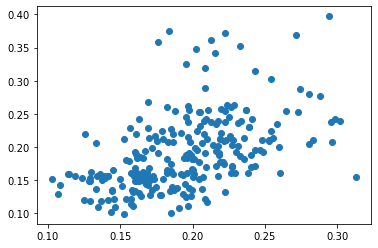

In [359]:
print(pearsonr(regr.predict(X_test), y_test))
plt.scatter(regr.predict(X_test), y_test)

In [259]:
y = data['txson_gt'].to_numpy()
X = data.iloc[:,4:-2].to_numpy()

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
from sklearn.model_selection import cross_val_predict
scalar = StandardScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
regr = MLPRegressor(hidden_layer_sizes = (10, 10),random_state=1, max_iter=1000)
mse = cross_val_score(regr, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
mse.mean()
# scalar.fit(X)
# X_train = scalar.transform(X)
# y_train = y
# regr = MLPRegressor(hidden_layer_sizes = (10,10), random_state=1, max_iter=1000)
# mse = cross_val_score(regr, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
# mse.mean()

(976, 11) (976,)


-0.007501695634814717

In [260]:
regr.predict(X_test)

NotFittedError: This MLPRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [239]:
pearsonr(regr.predict(X_train[:]), y_train[:])

(0.5163997637354293, 3.891390879615066e-51)

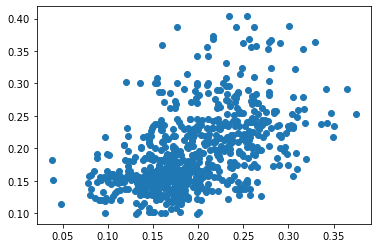

In [241]:
plt.scatter(regr.predict(X_train[:]), y_train[:])

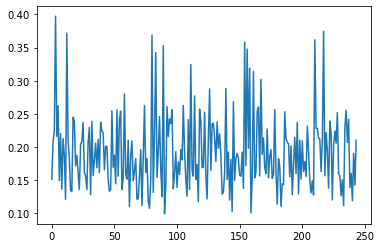

In [234]:
plt.plot(y_test[:])

In [198]:
X_train

array([[ 0.12919288,  1.24669848, -0.52859904, ...,  0.73493061,
        -0.75230676,  0.92082827],
       [-0.49253915, -0.09002161,  0.11656061, ..., -0.84439212,
         0.84196577, -0.62138964],
       [ 0.23269691, -0.47673864, -0.43182509, ..., -1.06742006,
         1.07952726, -0.66778217],
       ...,
       [-0.26052443, -0.60389791, -0.07698729, ..., -1.06733151,
         1.07943047, -0.34661881],
       [ 0.61845938, -1.36762016, -1.39956456, ...,  0.72832215,
        -0.74599046,  0.17791174],
       [ 0.66920332,  0.28935513, -0.43182509, ...,  0.68625769,
        -0.70420837,  0.88397662]])

In [194]:
X = data.iloc[0,1:11].to_numpy()
print(X)

[ 1.52839042e+02  3.79190521e+01  5.00000000e+01 -6.90990051e+02
  6.43202300e+06 -3.39740801e+00  9.54418458e+00  2.43182530e-01]


In [178]:
data.head()

,index,preff,inc_angle,clay,pow_mean,pow_var,pow_skew,pow_kurt,txson_gt
0,0,152.839042,37.919052,50.0,-690.990051,6432023.0,-3.397408,9.544185,0.243183
1,1,152.661684,37.938034,17.5,-690.990051,6432023.0,-3.397408,9.544185,0.241528
2,2,152.786237,37.957127,10.5,-690.990051,6432023.0,-3.397408,9.544185,0.241528
3,3,151.391626,37.976330,22.5,-690.990051,6432023.0,-3.397408,9.544185,0.256101
4,4,150.778259,37.995640,7.5,-690.990051,6432023.0,-3.397408,9.544185,0.244223


In [89]:
txson_gt = []
for i in range(jan_clean.shape[0]):
    day_num = int(jan_clean.iloc[i]['day_num'])
    sp_lat = jan_clean.iloc[i]['lat']
    sp_lon = jan_clean.iloc[i]['lon']
    for j in range(grid_corners.shape[0]):
        grid_lat_min = grid_corners.iloc[j]['LAT_corner_min']
        grid_lat_max = grid_corners.iloc[j]['LAT_corner_max']
        grid_lon_min = grid_corners.iloc[j]['LON_corner_min']
        grid_lon_max = grid_corners.iloc[j]['LON_corner_max']
        if ((sp_lat>grid_lat_min)&(sp_lat < grid_lat_max)&(sp_lon > grid_lon_min)&(sp_lon < grid_lon_max)):
            grid_ind = int(j)
#             print(grid_ind)
            break

    txson_gt.append(jan_txson.iloc[grid_ind][day_num+1])

In [92]:
jan_clean['txson_gt'] = txson_gt

C:\Users\mathurs\Anaconda3\envs\geo_env_2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
jan_clean

,day_num,lat,lon,preff,inc_angle,elevation,clay,sand,silt,depres,ndvi,txson_gt
0,1,30.232136,-98.908539,152.839042,37.919052,500.277008,50.0,22.1,27.9,201.0,4562,0.243183
1,1,30.241589,-98.847046,152.661684,37.938034,486.428375,17.5,43.0,39.5,201.0,4416,0.241528
2,1,30.251015,-98.785553,152.786237,37.957127,480.731262,10.5,76.0,13.5,201.0,3901,0.241528
3,1,30.260416,-98.724060,151.391626,37.976330,483.185364,22.5,39.8,37.7,46.0,5288,0.256101
4,1,30.269793,-98.662537,150.778259,37.995640,470.681946,7.5,85.9,6.6,201.0,5203,0.244223
...,...,...,...,...,...,...,...,...,...,...,...,...
264,31,30.363504,-98.838745,148.828110,19.828100,606.186829,22.5,39.8,37.7,30.0,5547,0.195833
265,31,30.347202,-98.778748,149.262553,19.788609,582.591492,50.0,22.1,27.9,30.0,5453,0.195833
266,31,30.330864,-98.718750,149.855231,19.749256,534.280823,46.0,5.6,48.4,86.0,4705,0.234905
267,31,30.314499,-98.658813,150.591187,19.710043,555.379211,21.0,39.0,40.0,36.0,5782,0.342300


In [64]:
grid_corners.columns

Index(['LAT_corner_min', 'LAT_corner_max', 'LON_corner_min', 'LON_corner_max'], dtype='object')

In [74]:
jan_clean

,day_num,lat,lon,preff,inc_angle,elevation,clay,sand,silt,depres,ndvi
0,1,30.232136,-98.908539,152.839042,37.919052,500.277008,50.0,22.1,27.9,201.0,4562
1,1,30.241589,-98.847046,152.661684,37.938034,486.428375,17.5,43.0,39.5,201.0,4416
2,1,30.251015,-98.785553,152.786237,37.957127,480.731262,10.5,76.0,13.5,201.0,3901
3,1,30.260416,-98.724060,151.391626,37.976330,483.185364,22.5,39.8,37.7,46.0,5288
4,1,30.269793,-98.662537,150.778259,37.995640,470.681946,7.5,85.9,6.6,201.0,5203
...,...,...,...,...,...,...,...,...,...,...,...
264,31,30.363504,-98.838745,148.828110,19.828100,606.186829,22.5,39.8,37.7,30.0,5547
265,31,30.347202,-98.778748,149.262553,19.788609,582.591492,50.0,22.1,27.9,30.0,5453
266,31,30.330864,-98.718750,149.855231,19.749256,534.280823,46.0,5.6,48.4,86.0,4705
267,31,30.314499,-98.658813,150.591187,19.710043,555.379211,21.0,39.0,40.0,36.0,5782
